In [18]:
from Bio import SeqIO
import pandas as pd


In [19]:

filename = "Plasmodium_falciparum_3D7_Genome.fasta"

In [20]:
record_dict = SeqIO.to_dict(SeqIO.parse(filename, "fasta"))

In [21]:
sequences = []
for key in record_dict.keys():
    sequences.append(list(record_dict[key].seq))

In [22]:
df = pd.DataFrame.from_dict({'chromosome_id': list(record_dict.keys()), 
                        'sequence': sequences})
df['length'] = df['sequence'].apply(lambda s: len(s))

In [23]:
df

,chromosome_id,sequence,length
0,Pf3D7_01_v3,"[T, G, A, A, C, C, C, T, A, A, A, A, C, C, T, ...",640851
1,Pf3D7_02_v3,"[A, A, C, C, C, T, A, A, A, C, C, C, T, A, A, ...",947102
2,Pf3D7_03_v3,"[T, A, A, A, C, C, C, T, A, A, A, T, C, T, C, ...",1067971
3,Pf3D7_04_v3,"[A, A, C, C, C, T, A, A, A, C, C, C, T, G, A, ...",1200490
4,Pf3D7_05_v3,"[C, T, A, A, A, C, C, C, T, G, A, A, C, C, C, ...",1343557
5,Pf3D7_06_v3,"[T, A, A, A, C, C, C, T, A, A, A, C, C, C, T, ...",1418242
6,Pf3D7_07_v3,"[A, A, A, C, C, C, T, A, A, A, C, C, C, T, G, ...",1445207
7,Pf3D7_08_v3,"[A, A, C, C, T, A, A, A, C, C, C, T, A, A, A, ...",1472805
8,Pf3D7_09_v3,"[A, A, C, C, C, T, G, A, A, C, C, C, T, A, A, ...",1541735
9,Pf3D7_10_v3,"[T, A, A, A, C, C, C, T, G, A, A, C, C, C, T, ...",1687656


In [24]:
chunk_size = 512

def split_into_chunks(sequence, chunk_size):
    """
    Splits a sequence into fixed-size chunks of `chunk_size`.
    """
    return [sequence[i:i + chunk_size] for i in range(0, len(sequence), chunk_size)]

# Create a new DataFrame where each row represents a chunk
chunked_data = []
for idx, row in df.iterrows():
    sequence_chunks = split_into_chunks(row['sequence'], chunk_size)
    for chunk_index, chunk in enumerate(sequence_chunks):
        chunked_data.append({
            'chromosome_id': row['chromosome_id'],
            'chunk': chunk,
            'chunk_index': chunk_index
        })

# Create the new DataFrame
chunked_df = pd.DataFrame(chunked_data)

# Display the first few rows of the resulting DataFrame
chunked_df.head(-5)


,chromosome_id,chunk,chunk_index
0,Pf3D7_01_v3,"[T, G, A, A, C, C, C, T, A, A, A, A, C, C, T, ...",0
1,Pf3D7_01_v3,"[C, T, T, T, T, C, A, T, T, C, C, T, T, A, C, ...",1
2,Pf3D7_01_v3,"[T, A, C, T, T, A, C, T, C, T, T, A, C, T, T, ...",2
3,Pf3D7_01_v3,"[T, T, A, A, C, T, T, A, C, T, T, T, C, A, T, ...",3
4,Pf3D7_01_v3,"[T, G, C, T, T, C, T, T, A, C, T, T, C, T, T, ...",4
...,...,...,...
45570,PFC10_API_IRAB,"[T, T, A, G, C, A, A, A, T, A, T, A, A, C, A, ...",57
45571,PFC10_API_IRAB,"[A, A, A, T, A, A, T, T, A, T, C, G, G, A, T, ...",58
45572,PFC10_API_IRAB,"[T, T, T, A, A, T, T, A, C, A, T, A, T, A, T, ...",59
45573,PFC10_API_IRAB,"[T, A, T, A, A, A, T, A, A, T, A, T, T, T, T, ...",60


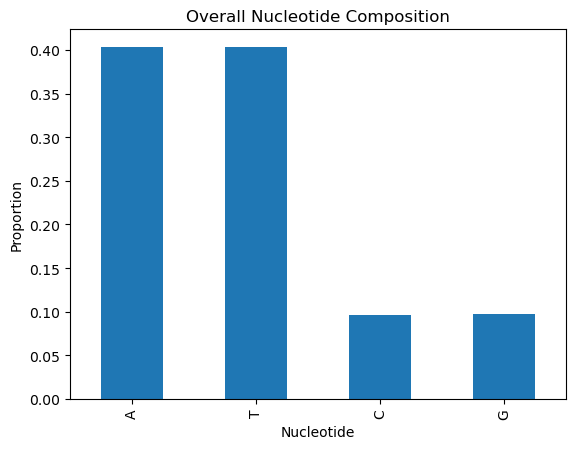

In [27]:
import pandas as pd
import numpy as np
from collections import Counter
from itertools import product
import matplotlib.pyplot as plt

Add a column for chunk lengths
chunked_df['chunk_length'] = chunked_df['chunk'].apply(len)
num_chromosomes = chunked_df['chromosome_id'].nunique()
total_chunks = len(chunked_df)
chunk_length_stats = chunked_df['chunk_length'].describe()

#Nucleotide Composition Analysis
def nucleotide_composition(chunk):
    counts = Counter(chunk)
    total = sum(counts.values())
    return {nuc: counts.get(nuc, 0) / total for nuc in 'ATCG'}

chunked_df['nucleotide_composition'] = chunked_df['chunk'].apply(nucleotide_composition)
composition_df = pd.DataFrame(chunked_df['nucleotide_composition'].tolist(), index=chunked_df.index)
overall_composition = composition_df.mean()

# Save nucleotide composition data to CSV
chunked_df['nucleotide_composition'].apply(pd.Series).to_csv('Nucleotide_Composition.csv', index=False)

# Visualization: Overall Nucleotide Composition
composition_df.mean().plot(kind='bar', title='Overall Nucleotide Composition')
plt.xlabel('Nucleotide')
plt.ylabel('Proportion')
plt.show()


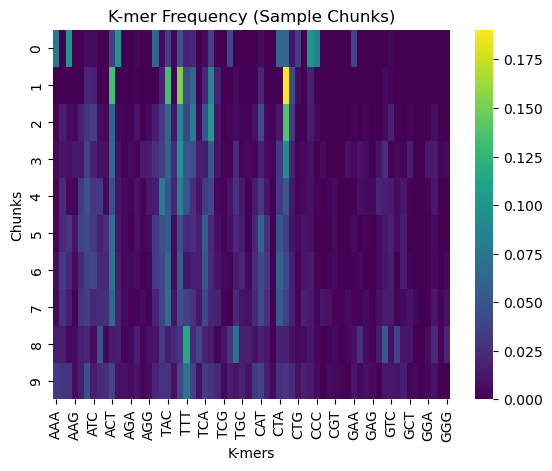

In [28]:
import pandas as pd
import numpy as np
from collections import Counter
from itertools import product
import matplotlib.pyplot as plt
import seaborn as sns

# Step 4: K-mer Frequency Analysis
def kmer_frequency(chunk, k=3):
    if len(chunk) < k:
        return {''.join(kmer): 0 for kmer in product('ATCG', repeat=k)}
    kmers = [''.join(kmer) for kmer in product('ATCG', repeat=k)]
    counts = Counter([''.join(chunk[i:i+k]) for i in range(len(chunk) - k + 1)])
    total = sum(counts.values())
    return {kmer: counts.get(kmer, 0) / total for kmer in kmers}

chunked_df['kmer_frequency'] = chunked_df['chunk'].apply(kmer_frequency)
kmer_df = pd.DataFrame(chunked_df['kmer_frequency'].tolist(), index=chunked_df.index)

# Save k-mer frequency data to CSV
kmer_df.to_csv('Kmer_Frequency.csv', index=False)

# Visualization: Heatmap of K-mer Frequencies
sns.heatmap(kmer_df.iloc[:10], cmap='viridis')
plt.title('K-mer Frequency (Sample Chunks)')
plt.xlabel('K-mers')
plt.ylabel('Chunks')
plt.show()


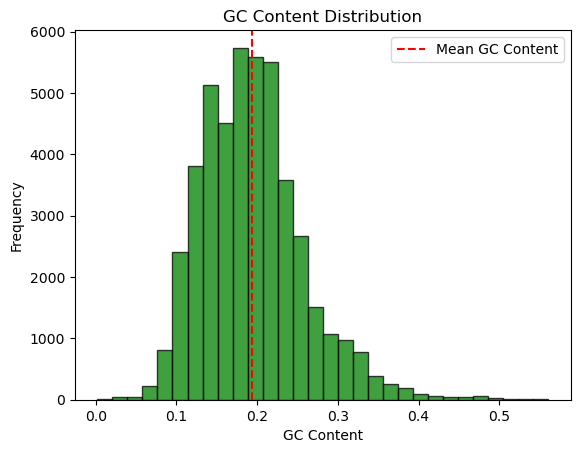

GC-Similarity Correlation:
                   gc_content  chunk_similarity
gc_content           1.00000          -0.69414
chunk_similarity    -0.69414           1.00000


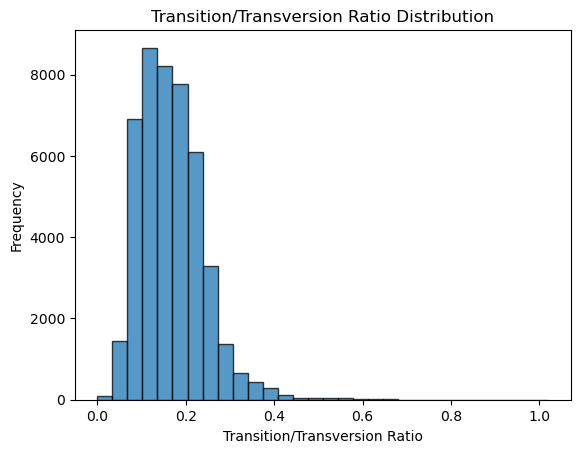

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate GC content for each chunk (proportion of G and C nucleotides).
chunked_df['gc_content'] = chunked_df['chunk'].apply(
    lambda chunk: (chunk.count('G') + chunk.count('C')) / len(chunk) if len(chunk) > 0 else 0
)

# Visualize GC content with a histogram and mark the average with a red line.
plt.hist(chunked_df['gc_content'], bins=30, alpha=0.75, edgecolor='black', color='green')
plt.axvline(chunked_df['gc_content'].mean(), color='red', linestyle='--', label='Mean GC Content')
plt.title("GC Content Distribution")
plt.xlabel("GC Content")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# Calculate similarity between consecutive chunks in the same chromosome.
def calculate_similarity(seq1, seq2):
    if seq1 is None or seq2 is None:
        return None
    min_len = min(len(seq1), len(seq2))
    return sum(1 for a, b in zip(seq1[:min_len], seq2[:min_len]) if a == b) / min_len

chunked_df['chunk_similarity'] = (
    chunked_df.groupby('chromosome_id')['chunk']
    .apply(lambda group: group.shift().combine(group, calculate_similarity))
    .reset_index(level=0, drop=True)
)

# Check correlation between GC content and chunk similarity.
gc_similarity_correlation = chunked_df[['gc_content', 'chunk_similarity']].corr()
print("GC-Similarity Correlation:\n", gc_similarity_correlation)

# Plot the distribution of transition/transversion ratios (if available).
plt.hist(chunked_df['transition_transversion_ratio'], bins=30, alpha=0.75, edgecolor='black')
plt.title("Transition/Transversion Ratio Distribution")
plt.xlabel("Transition/Transversion Ratio")
plt.ylabel("Frequency")
plt.show()

# Save the updated DataFrame and statistics.
chunked_df.to_csv('Updated_Chunked.csv', index=False)
